# Deep Crossentropy method

In this section we'll extend your CEM implementation with neural networks! You will train a multi-layer neural network to solve simple continuous state space games. __Please make sure you're done with tabular crossentropy method from the previous notebook.__


(Trong phần này, chúng ta sẽ mở rộng việc triển khai CEM (Crossentropy Method) của bạn bằng cách sử dụng mạng nơ-ron! Bạn sẽ huấn luyện một mạng nơ-ron nhiều lớp để giải quyết các trò chơi với không gian trạng thái liên tục đơn giản. Hãy đảm bảo rằng bạn đã hoàn thành phương pháp crossentropy dạng bảng (tabular crossentropy method) từ notebook trước.)
![img](https://watanimg.elwatannews.com/old_news_images/large/249765_Large_20140709045740_11.jpg)



In [22]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
# Install gymnasium if you didn't
!pip install "gymnasium[toy_text,classic_control]"

In [23]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  
# Hiển thị biểu đồ trực tiếp trong notebook

# Nếu bạn thấy lỗi "<classname> has no attribute .env", hãy xóa .env hoặc cập nhật thư viện gym
env = gym.make("CartPole-v0", render_mode="rgb_array").env  # Tạo môi trường CartPole với chế độ hiển thị hình ảnh

env.reset()  # Đặt lại môi trường về trạng thái ban đầu
n_actions = env.action_space.n  # Lấy số lượng hành động có thể thực hiện trong môi trường
state_dim = env.observation_space.shape[0]  # Lấy số chiều của vector trạng thái

plt.imshow(env.render())  # Hiển thị hình ảnh của môi trường
print("state vector dim =", state_dim)  # In ra số chiều của vector trạng thái
print("n_actions =", n_actions)  # In ra số lượng hành động

env.close()  # Đóng môi trường để giải phóng tài nguyên

state vector dim = 4
n_actions = 2


c:\Anaconda\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


# Neural Network Policy

For this assignment we'll utilize the simplified neural network implementation from __[Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)__. Here's what you'll need:

(Trong bài tập này, chúng ta sẽ sử dụng triển khai đơn giản của mạng nơ-ron từ Scikit-learn. Dưới đây là những gì bạn cần:)

* `agent.partial_fit(states, actions)` - make a single training pass over the data. Maximize the probability of :actions: from :states:

(agent.partial_fit(states, actions) - thực hiện một lượt huấn luyện trên dữ liệu. Tối đa hóa xác suất của các hành động (actions) từ các trạng thái (states).)

* `agent.predict_proba(states)` - predict probabilities of all actions, a matrix of shape __[len(states), n_actions]__

(agent.predict_proba(states) - dự đoán xác suất của tất cả các hành động, trả về một ma trận có kích thước [len(states), n_actions].)

In [24]:
from sklearn.neural_network import MLPClassifier  # Import lớp MLPClassifier từ thư viện Scikit-learn

# Khởi tạo một mạng nơ-ron với 2 tầng ẩn, mỗi tầng có 20 nơ-ron
agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),  # Cấu trúc mạng nơ-ron: 2 tầng ẩn, mỗi tầng có 20 nơ-ron
    activation="tanh",  # Hàm kích hoạt sử dụng là "tanh"
)

# Khởi tạo agent để phù hợp với kích thước không gian trạng thái và số lượng hành động
agent.partial_fit(
    [env.reset()[0]] * n_actions,  # Trạng thái ban đầu được nhân lên để khớp với số lượng hành động
    range(n_actions),  # Các nhãn hành động (0, 1, ..., n_actions-1)
    range(n_actions),  # Các lớp hành động (0, 1, ..., n_actions-1)
)

MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 20))

In [25]:
def generate_session(env, agent, t_max=1000):
    """
    Chơi một phiên chơi đơn lẻ bằng cách sử dụng mạng nơ-ron của agent.
    Kết thúc khi trò chơi hoàn thành hoặc sau :t_max: bước.
    """
    states, actions = [], []  # Danh sách lưu trữ các trạng thái và hành động
    total_reward = 0  # Tổng phần thưởng thu được trong phiên chơi

    s, _ = env.reset()  # Đặt lại môi trường về trạng thái ban đầu

    for t in range(t_max):  # Lặp qua tối đa t_max bước

        # Sử dụng agent để dự đoán một vector xác suất hành động cho trạng thái :s:
        # probs = <YOUR CODE>
        probs = agent.predict_proba([s])[0]  # Dự đoán xác suất cho các hành động từ trạng thái hiện tại

        assert probs.shape == (env.action_space.n,), "Đảm bảo xác suất là một vector (gợi ý: np.reshape)"

        # Sử dụng xác suất đã dự đoán để chọn một hành động
        # Lấy mẫu hành động theo tỷ lệ xác suất, không chỉ chọn hành động có xác suất cao nhất
        #a = <YOUR CODE
        a = np.random.choice(env.action_space.n, p=probs)  # Chọn hành động dựa trên xác suất

        new_s, r, terminated, truncated, _ = env.step(a)  # Thực hiện hành động và nhận kết quả từ môi trường

        # Ghi lại các trạng thái và hành động như trước đây
        states.append(s)  # Lưu trạng thái hiện tại
        actions.append(a)  # Lưu hành động đã thực hiện
        total_reward += r  # Cộng dồn phần thưởng

        s = new_s  # Cập nhật trạng thái mới
        if terminated or truncated:  # Kiểm tra nếu trò chơi kết thúc
            break
    return states, actions, total_reward  # Trả về danh sách trạng thái, hành động và tổng phần thưởng

In [26]:
dummy_states, dummy_actions, dummy_reward = generate_session(env, agent, t_max=5)
# Gọi hàm generate_session để tạo một phiên chơi với môi trường (env) và agent.
# t_max=5: Giới hạn số bước tối đa trong phiên chơi là 5.
# Kết quả trả về gồm:
# - dummy_states: Danh sách các trạng thái trong phiên chơi.
# - dummy_actions: Danh sách các hành động đã thực hiện.
# - dummy_reward: Tổng phần thưởng nhận được trong phiên chơi.

print("states:", np.stack(dummy_states))
# In ra danh sách các trạng thái dưới dạng mảng numpy (stack các trạng thái lại với nhau).

print("actions:", dummy_actions)
# In ra danh sách các hành động đã thực hiện trong phiên chơi.
# 0 là di chuyến sang trái, 1 là di chuyển sang phải.

print("reward:", dummy_reward)
# In ra tổng phần thưởng nhận được trong phiên chơi.

states: [[-0.02996574 -0.03888028 -0.01100397  0.01582226]
 [-0.03074335  0.15639775 -0.01068752 -0.28031212]
 [-0.02761539  0.3516705  -0.01629377 -0.57634664]
 [-0.02058198  0.54701704 -0.0278207  -0.8741177 ]
 [-0.00964164  0.74250597 -0.04530305 -1.1754158 ]]
actions: [1, 1, 1, 1, 1]
reward: 5.0


### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

(Deep CEM sử dụng chính xác cùng chiến lược như CEM thông thường, vì vậy bạn có thể sao chép mã hàm từ notebook trước.)

The only difference is that now each observation is not a number but a `float32` vector.

(Sự khác biệt duy nhất là bây giờ mỗi quan sát không phải là một số mà là một vector float32.)

In [27]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Chọn các trạng thái và hành động từ các phiên chơi có phần thưởng >= percentile
    :param states_batch: danh sách các danh sách trạng thái, states_batch[session_i][t]
    :param actions_batch: danh sách các danh sách hành động, actions_batch[session_i][t]
    :param rewards_batch: danh sách phần thưởng, rewards_batch[session_i]

    :returns: elite_states, elite_actions, cả hai là danh sách 1D của các trạng thái và hành động tương ứng từ các phiên chơi ưu tú

    Hãy trả về các trạng thái và hành động ưu tú theo thứ tự ban đầu
    [tức là được sắp xếp theo số thứ tự phiên chơi và thời gian trong phiên chơi]

    Nếu bạn cảm thấy bối rối, hãy xem các ví dụ bên dưới. Đừng giả định rằng các trạng thái là số nguyên
    (chúng sẽ trở nên khác sau này).
    """
    #<YOUR CODE: copy-paste your implementation from the previous notebook>
    # Tính ngưỡng phần thưởng dựa trên percentile
    reward_threshold = np.percentile(rewards_batch, percentile)

    # Chọn các chỉ số của các phiên chơi có phần thưởng >= ngưỡng
    elite_indices = [i for i, reward in enumerate(rewards_batch) if reward >= reward_threshold]

    # Lấy các trạng thái và hành động từ các phiên chơi ưu tú
    elite_states = [state for i in elite_indices for state in states_batch[i]]  # Lấy tất cả trạng thái từ các phiên chơi ưu tú
    elite_actions = [action for i in elite_indices for action in actions_batch[i]]  # Lấy tất cả hành động từ các phiên chơi ưu tú

    return elite_states, elite_actions


# Training loop
Generate sessions, select N best and fit to those.

In [28]:
from IPython.display import clear_output


def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    Một hàm tiện ích để hiển thị tiến trình huấn luyện.
    Không có toán học phức tạp ở đây, chỉ là các biểu đồ.
    """

    # Tính phần thưởng trung bình từ lô phần thưởng hiện tại
    mean_reward = np.mean(rewards_batch)
    # Tính ngưỡng phần thưởng dựa trên percentile (phần trăm)
    threshold = np.percentile(rewards_batch, percentile)
    # Thêm giá trị phần thưởng trung bình và ngưỡng vào log để theo dõi
    log.append([mean_reward, threshold])

    # Xóa đầu ra trước đó để hiển thị đầu ra mới
    clear_output(True)
    # In ra phần thưởng trung bình và ngưỡng
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    
    # Tạo một biểu đồ với kích thước 8x4
    plt.figure(figsize=[8, 4])
    
    # Biểu đồ đầu tiên: biểu đồ đường hiển thị phần thưởng trung bình và ngưỡng
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label="Mean rewards")  # Phần thưởng trung bình
    plt.plot(list(zip(*log))[1], label="Reward thresholds")  # Ngưỡng phần thưởng
    plt.legend()  # Hiển thị chú thích
    plt.grid()  # Hiển thị lưới

    # Biểu đồ thứ hai: biểu đồ histogram hiển thị phân phối phần thưởng
    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)  # Phân phối phần thưởng
    plt.vlines(
        [np.percentile(rewards_batch, percentile)],  # Vẽ đường dọc tại ngưỡng phần thưởng
        [0],
        [100],
        label="percentile",  # Nhãn cho đường dọc
        color="red",  # Màu đỏ
    )
    plt.legend()  # Hiển thị chú thích
    plt.grid()  # Hiển thị lưới

    # Hiển thị biểu đồ
    plt.show()


mean reward = 309.480, threshold=212.000


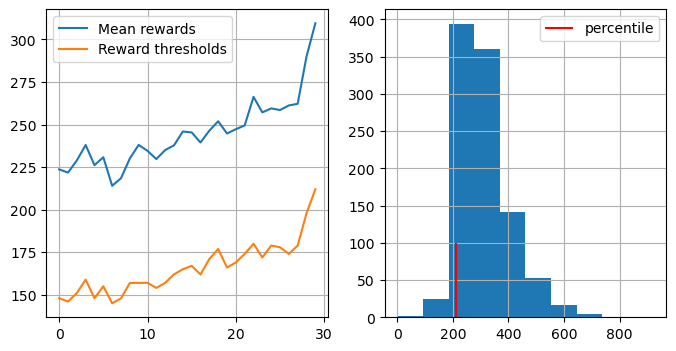

You Win! You may stop training now via KeyboardInterrupt.


In [ ]:
n_sessions = 100  # Số lượng phiên chơi (sessions) được tạo trong mỗi vòng lặp
percentile = 70  # Phần trăm ngưỡng để chọn các phiên chơi ưu tú
log = []  # Danh sách để lưu trữ tiến trình huấn luyện

for i in range(100):  # Lặp qua tối đa 100 vòng huấn luyện
    # Tạo danh sách các phiên chơi mới
    sessions = [generate_session(env, agent) for _ in range(n_sessions)]
    # Mỗi phiên chơi trả về danh sách trạng thái, hành động và tổng phần thưởng

    # Tách các trạng thái, hành động và phần thưởng từ các phiên chơi
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    # states_batch: Danh sách các danh sách trạng thái từ các phiên chơi
    # actions_batch: Danh sách các danh sách hành động từ các phiên chơi
    # rewards_batch: Danh sách tổng phần thưởng từ các phiên chơi

    # Chọn các trạng thái và hành động ưu tú dựa trên phần thưởng
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=percentile)
    # elite_states: Danh sách các trạng thái từ các phiên chơi ưu tú
    # elite_actions: Danh sách các hành động từ các phiên chơi ưu tú

    # Huấn luyện agent bằng cách sử dụng các trạng thái và hành động ưu tú
    agent.partial_fit(elite_states, elite_actions)
    # partial_fit: Huấn luyện mạng nơ-ron để dự đoán hành động từ trạng thái

    # Hiển thị tiến trình huấn luyện
    show_progress(
        rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)]
    )
    # show_progress: Hiển thị biểu đồ tiến trình và thông tin phần thưởng

    # Dừng huấn luyện nếu phần thưởng trung bình vượt quá 190
    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        break  # Thoát khỏi vòng lặp huấn luyện

# Results

In [10]:
!pip install moviepy

In [36]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("CartPole-v0", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, agent) for _ in range(100)]


c:\Anaconda\Lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
c:\Anaconda\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Reinforcement Learning\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [37]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


# Homework part I

### Tabular crossentropy method

You may have noticed that the taxi problem quickly converges from -100 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

### Tasks
- __1.1__ (2 pts) Find out how the algorithm performance changes if you use a different `percentile` and/or `n_sessions`. Provide here some figures so we can see how the hyperparameters influence the performance.
- __1.2__ (1 pts) Tune the algorithm to end up with positive average score.

It's okay to modify the existing code.


```<Describe what you did here>```

# Homework part II

### Deep crossentropy method

By this moment, you should have got enough score on [CartPole-v0](https://gymnasium.farama.org/environments/classic_control/cart_pole/) to consider it solved (see the link). It's time to try something harder.

* if you have any trouble with CartPole-v0 and feel stuck, feel free to ask us or your peers for help.

### Tasks

* __2.1__ (3 pts) Pick one of environments: `MountainCar-v0` or `LunarLander-v2`.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get some of the points depending on the result, so don't be afraid to submit it.
  
  
* __2.2__ (up to 6 pts) Devise a way to speed up training against the default version
  * Obvious improvement: use [`joblib`](https://joblib.readthedocs.io/en/latest/). However, note that you will probably need to spawn a new environment in each of the workers instead of passing it via pickling. (2 pts)
  * Try re-using samples from 3-5 last iterations when computing threshold and training. (2 pts)
  * Obtain __-100__ at `MountainCar-v0` or __+200__ at `LunarLander-v2` (2 pts). Feel free to experiment with hyperparameters, architectures, schedules etc.
  
__Please list what you did in Anytask submission form__. This reduces probability that somebody misses something.
  
  
### Tips
* Gymnasium pages: [MountainCar](https://gymnasium.farama.org/environments/classic_control/mountain_car/), [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 10% are better, than if you use percentile 20% as threshold, R >= threshold __fails to cut off bad sessions__ while R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it doesn't train, it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.

You may find the following snippet useful:

In [13]:
def visualize_mountain_car(env, agent):
    # Compute policy for all possible x and v (with discretization)
    xs = np.linspace(env.min_position, env.max_position, 100)
    vs = np.linspace(-env.max_speed, env.max_speed, 100)

    grid = np.dstack(np.meshgrid(xs, vs[::-1])).transpose(1, 0, 2)
    grid_flat = grid.reshape(len(xs) * len(vs), 2)
    probs = (
        agent.predict_proba(grid_flat).reshape(len(xs), len(vs), 3).transpose(1, 0, 2)
    )

    # # The above code is equivalent to the following:
    # probs = np.empty((len(vs), len(xs), 3))
    # for i, v in enumerate(vs[::-1]):
    #     for j, x in enumerate(xs):
    #         probs[i, j, :] = agent.predict_proba([[x, v]])[0]

    # Draw policy
    f, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(
        probs,
        extent=(env.min_position, env.max_position, -env.max_speed, env.max_speed),
        aspect="auto",
    )
    ax.set_title("Learned policy: red=left, green=nothing, blue=right")
    ax.set_xlabel("position (x)")
    ax.set_ylabel("velocity (v)")

    # Sample a trajectory and draw it
    states, actions, _ = generate_session(env, agent)
    states = np.array(states)
    ax.plot(states[:, 0], states[:, 1], color="white")

    # Draw every 3rd action from the trajectory
    for (x, v), a in zip(states[::3], actions[::3]):
        if a == 0:
            plt.arrow(x, v, -0.1, 0, color="white", head_length=0.02)
        elif a == 2:
            plt.arrow(x, v, 0.1, 0, color="white", head_length=0.02)


with gym.make("MountainCar-v0", render_mode="rgb_arrary").env as env:
    visualize_mountain_car(env, agent)


c:\Anaconda\Lib\site-packages\gymnasium\envs\registration.py:736: UserWarning: WARN: The environment is being initialised with render_mode='rgb_arrary' that is not in the possible render_modes (['human', 'rgb_array']).
  logger.warn(


AttributeError: 'OrderEnforcing' object has no attribute 'min_position'

### Bonus tasks

* __2.3 bonus__ (2 pts) Try to find a network architecture and training params that solve __both__ environments above (_Points depend on implementation. If you attempted this task, please mention it in Anytask submission._)

* __2.4 bonus__ (4 pts) Solve continuous action space task with `MLPRegressor` or similar.
  * Since your agent only predicts the "expected" action, you will have to add noise to ensure exploration.
  * Choose one of [MountainCarContinuous-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/) (90+ pts to solve), [LunarLanderContinuous-v2](https://gymnasium.farama.org/environments/box2d/lunar_lander/) (`env = gym.make("LunarLander-v2", continuous=True)`)(200+ pts to solve)
  * 4 points for solving. Slightly less for getting some results below solution threshold. Note that discrete and continuous environments may have slightly different rules, aside from action spaces.